# AoU FHIR & OMOP Analysis
Information about Sync for Science and OMOP patients, and comparing the data of each.

First, define the locations of the data we wish to analyze and compare, and import the necessary modules.

In [1]:
import os
import json
import pandas as pd
import omop_analyze
import fhir_analyze
import aou_analysis

current_directory = os.getcwd()
omop_directory = "\\omop\\20190823"
fhir_directory = "\\fhir\\Participant"

*the `omop_analyze` module takes care of navigating and importing omop CSV raw data. The raw csvs are located as flat files under the `omop_directory`. The `fhir_analyze` module navigates and imports the json files per category, per patient. The patient directories are located under the `fhir_directory` location, each patient has a folder named by their `patient_id`. Each patient has `.json` files per data category. Files are named by category, as defined by the FHIR spec resource types.*

*`aou_analysis` contains all the functions for accessing and analysing the data retrieved. It mainly creates and manipulates pandas DataFrames, and counts details about data entries.*

## 1: FHIR Summary
pull in fhir data, let's find some basic data on the number of patients and number of entries retrived. `fhir_patients` is a dictionary of `patient_id`s, with deeply nested key value pairs containing all the raw data. This will be used as a basis for all following analysis.

In [2]:
fhir_patients = fhir_analyze.traverse_directory(current_directory+fhir_directory)

got 83 s4s participants


### 1 a: Histogram showing counts for each data category, across the population
For each patient, walk through all the json data entries, and count how many times each category appears. This generally shows the range of data categories in the FHIR data.

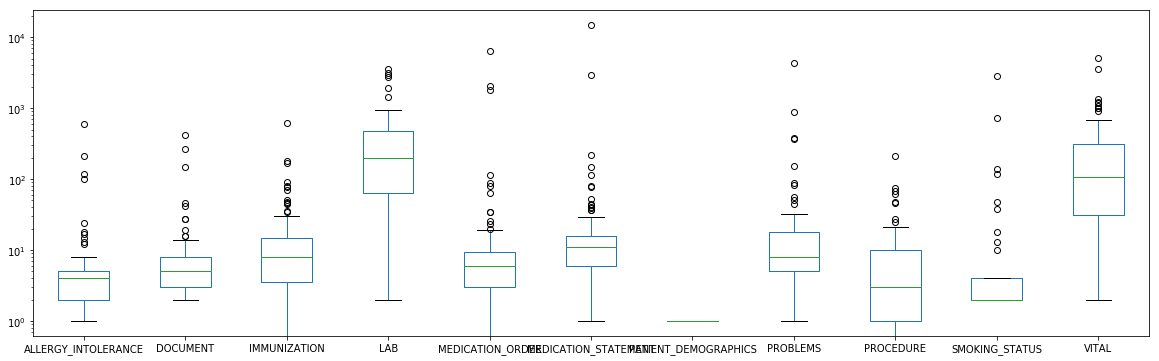

In [14]:
fhir_category_counts_df = aou_analysis.fhir_plot_category_counts(fhir_patients)
display(fhir_category_counts_df.plot(kind='box', figsize=(20,6), logy=True))

*This graph is plotted on an logarithmic y axis. While most categories have an average of 5-10 entries, lab and vital categories average in the hundreds. Patient demographics will only ever have one entry. Immunization, medication_order, and prodecures have several patients with zero entries.*

### 1 b: raw counts of histogram buckets

In [4]:
aou_analysis.export_df(fhir_category_counts_df, 'export/fhir_category_counts.csv')

*To export this data, patient data must be anonymized. The python function <> to create ranges of data values, and collected into buckets over all patients. This was put into a new DataFrame*

*The DataFrame was then exported into a csv file during the creation of this report. It can be found in the `export/` folder.*

### 1 c: Most common code systems for each data category
Each [FHIR entry](https://www.hl7.org/fhir/bundle-definitions.html#Bundle.entry) has a coding, which is a system and code pair. A full mapping of the structure of these entries can be found [in the FHIR JSON Tree](#fhir_tree). `code_system_counts` takes a list of patient entries, navigates to the coding of that type of entry via `aou_analysis.path_for_resource`, and counts the system it finds there. 

`configure_tables()` formats the output that's shown below, to prevent default behavior of hiding entries under ellipses. 

In [5]:
aou_analysis.configure_tables()
fhir_systems = aou_analysis.code_system_counts(fhir_patients)
for category, counter in fhir_systems.items():
    df = pd.DataFrame(counter.most_common())
    df.index.name = category
    df.rename(columns={0:'system', 1:'count'}, inplace=True)
    display(df)
    aou_analysis.export_df(df, 'export/fhir_systems_'+category+'.csv')

""
PATIENT_DEMOGRAPHICS


,system,count
SMOKING_STATUS,,
0,http://loinc.org,591
1,http://snomed.info/sct,427


,system,count
PROBLEMS,,
0,http://snomed.info/sct,3875
1,http://hl7.org/fhir/sid/icd-9-cm,1537
2,urn:oid:2.16.840.1.113883.6.90,1154
3,http://hl7.org/fhir/sid/icd-9-cm/diagnosis,990
4,http://hl7.org/fhir/sid/icd-10-cm,810


,system,count
MEDICATION_ORDER,,
0,http://www.nlm.nih.gov/research/umls/rxnorm,5031
1,None,36
2,http://hl7.org/fhir/sid/ndc,5


,system,count
MEDICATION_STATEMENT,,
0,http://www.nlm.nih.gov/research/umls/rxnorm,7737
1,https://apis.followmyhealth.com/fhir/id/translation,23


,system,count
ALLERGY_INTOLERANCE,,
0,http://www.nlm.nih.gov/research/umls/rxnorm,431
1,http://fdasis.nlm.nih.gov,202
2,http://hl7.org/fhir/ndfrt,162
3,http://snomed.info/sct,134
4,http://hl7.org/fhir/sid/ndc,25
5,None,25


,system,count
LAB,,
0,http://loinc.org,26149


,system,count
VITAL,,
0,http://loinc.org,57167
1,http://snomed.info/sct,1597


,system,count
PROCEDURE,,
0,http://www.ama-assn.org/go/cpt,268
1,urn:oid:1.2.840.114350.1.13.202.2.7.2.696580,122
2,http://snomed.info/sct,119
3,urn:oid:1.2.840.114350.1.13.362.2.7.2.696580,36
4,urn:oid:1.2.840.114350.1.13.324.2.7.2.696580,28
5,urn:oid:2.16.840.1.113883.6.14,17
6,urn:oid:1.2.840.114350.1.13.71.2.7.2.696580,8
7,None,6


,system,count
IMMUNIZATION,,
0,http://hl7.org/fhir/sid/cvx,1773
1,http://hl7.org/fhir/sid/ndc,272
2,http://www.ama-assn.org/go/cpt,110


,system,count
DOCUMENT,,
0,http://loinc.org,531


*The urn:oid systems are coded by a hospital's individual EPIC systems. I've contacted EPIC and the hospital systems, but I haven't been able to get any more information about these.*

### 1 d: Most common standardized codes for each data category
`aou_analysis.coding_counts` is similar to `aou_analysis.code_system_counts`, but combines similar codings via `aou_analysis.most_common_synonym` to put all codings found together into the same combined count. Codings are a list of systems and codes, often only one item in the list, but where there are multiple, that's what gets combined in `most_common_synonym`.

In [6]:
fhir_coding_results = aou_analysis.coding_counts(fhir_patients)
for category, table in fhir_coding_results['table'].items():
    df = pd.DataFrame(table)
    df.index.name = category
    display(df)
    aou_analysis.export_df(df, 'export/fhir_codings_'+category+'.csv')

""
PATIENT_DEMOGRAPHICS


,code,count,display,system
SMOKING_STATUS,,,,
0,88031-0,237,None,http://loinc.org
1,72166-2,234,Tobacco smoking status NHIS,http://loinc.org
2,714151003,161,Environmental tobacco smoke exposure (observable entity),http://snomed.info/sct
3,8663-7,109,None,http://loinc.org
4,363905002,54,Details of alcohol drinking behavior (observable entity),http://snomed.info/sct
5,224130005,24,Household composition (observable entity),http://snomed.info/sct
6,48766-0,20,None,http://loinc.org
7,266918002,17,Tobacco smoking consumption (observable entity),http://snomed.info/sct
8,73985-4,11,None,http://loinc.org


,code,count,display,system
PROBLEMS,,,,
0,73211009,264,None,http://snomed.info/sct
1,305058001,188,None,http://snomed.info/sct
2,77386006,122,Patient currently pregnant (finding),http://snomed.info/sct
3,29857009,106,None,http://snomed.info/sct
4,55822004,90,Hyperlipidemia (disorder),http://snomed.info/sct
5,195967001,77,None,http://snomed.info/sct
6,300.00,77,"Anxiety state, unspecified",http://hl7.org/fhir/sid/icd-9-cm
7,228315001,72,Binge drinker (finding),http://snomed.info/sct
8,25064002,66,None,http://snomed.info/sct


,code,count,display,system
MEDICATION_ORDER,,,,
0,308416,680,Aspir 81 oral delayed release tablet,http://www.nlm.nih.gov/research/umls/rxnorm
1,243670,195,aspirin 81 mg oral tablet,http://www.nlm.nih.gov/research/umls/rxnorm
2,3498,140,Diphenhydramine,http://www.nlm.nih.gov/research/umls/rxnorm
3,161,135,None,http://www.nlm.nih.gov/research/umls/rxnorm
4,8640,135,None,http://www.nlm.nih.gov/research/umls/rxnorm
5,23950,130,EMLA,http://www.nlm.nih.gov/research/umls/rxnorm
6,5224,120,heparin,http://www.nlm.nih.gov/research/umls/rxnorm
7,259966,105,methylPREDNISolone 4 mg oral tablet,http://www.nlm.nih.gov/research/umls/rxnorm
8,318272,85,"aspirin 81 mg oral tablet, chewable",http://www.nlm.nih.gov/research/umls/rxnorm


,code,count,display,system
MEDICATION_STATEMENT,,,,
0,3498,336,Diphenhydramine,http://www.nlm.nih.gov/research/umls/rxnorm
1,8640,325,None,http://www.nlm.nih.gov/research/umls/rxnorm
2,161,324,None,http://www.nlm.nih.gov/research/umls/rxnorm
3,23950,312,EMLA,http://www.nlm.nih.gov/research/umls/rxnorm
4,5224,288,heparin,http://www.nlm.nih.gov/research/umls/rxnorm
5,313782,194,acetaminophen 325 mg tablet,http://www.nlm.nih.gov/research/umls/rxnorm
6,202433,180,Tylenol,http://www.nlm.nih.gov/research/umls/rxnorm
7,203457,168,Benadryl,http://www.nlm.nih.gov/research/umls/rxnorm
8,10379,108,Testosterone,http://www.nlm.nih.gov/research/umls/rxnorm


,code,count,display,system
ALLERGY_INTOLERANCE,,,,
0,2670,59,None,http://www.nlm.nih.gov/research/umls/rxnorm
1,716186003,47,No known allergy,http://snomed.info/sct
2,QE1QX6B99R,40,None,http://fdasis.nlm.nih.gov
3,N0000007394,26,LATEX,http://hl7.org/fhir/ndfrt
4,256349002,25,Peanut - dietary (substance),http://snomed.info/sct
5,111088007,25,Latex (substance),http://snomed.info/sct
6,256259004,25,Pollen (substance),http://snomed.info/sct
7,NA,25,sulfa products,None
8,N0000008034,22,SULFA (SULFONAMIDE ANTIBIOTICS),http://hl7.org/fhir/ndfrt


,code,count,display,system
LAB,,,,
0,2160-0,579,Creatinine [Mass/volume] in Serum or Plasma,http://loinc.org
1,2345-7,553,Glucose [Mass/volume] in Serum or Plasma,http://loinc.org
2,17861-6,542,Calcium [Mass/volume] in Serum or Plasma,http://loinc.org
3,3094-0,537,Urea nitrogen [Mass/volume] in Serum or Plasma,http://loinc.org
4,2823-3,533,Potassium [Moles/volume] in Serum or Plasma,http://loinc.org
5,2075-0,519,Chloride [Moles/volume] in Serum or Plasma,http://loinc.org
6,2028-9,499,"Carbon dioxide, total [Moles/volume] in Serum or Plasma",http://loinc.org
7,6690-2,494,Leukocytes [#/volume] in Blood by Automated count,http://loinc.org
8,789-8,489,Erythrocytes [#/volume] in Blood by Automated count,http://loinc.org


,code,count,display,system
VITAL,,,,
0,8716-3,28222,Vital signs,http://loinc.org
1,39156-5,713,None,http://loinc.org
2,225908003,356,Pain score (observable entity),http://snomed.info/sct
3,86198006,160,Influenza vaccination (procedure),http://snomed.info/sct
4,19928-1,125,None,http://loinc.org
5,8327-9,113,None,http://loinc.org
6,41904-4,100,None,http://loinc.org
7,8478-0,93,None,http://loinc.org
8,3151-8,90,None,http://loinc.org


,code,count,display,system
PROCEDURE,,,,
0,86580,52,PR TB INTRADERMAL TEST,http://www.ama-assn.org/go/cpt
1,10224242,41,GENERAL PROCEDURE,urn:oid:1.2.840.114350.1.13.202.2.7.2.696580
2,90412006,25,"Colonoscope, device (physical object)",http://snomed.info/sct
3,69210,19,PR REMOVE IMPACTED EAR WAX,http://www.ama-assn.org/go/cpt
4,G0121,17,PR COLON CA SCRN NOT HI RSK IND,urn:oid:2.16.840.1.113883.6.14
5,93351,15,"PR ECHO HEART XTHORACIC, STRESS/REST, W CONTIN ECG",http://www.ama-assn.org/go/cpt
6,93010,15,"ELECTROCARDIOGRAM, ROUTINE W/AT LEAST 12 LEADS",http://www.ama-assn.org/go/cpt
7,128454,13,SPIROMETRY - NURSING,urn:oid:1.2.840.114350.1.13.324.2.7.2.696580
8,92133,12,PR COMPUTERIZED OPHTHALMIC IMAGING OPTIC NERVE,http://www.ama-assn.org/go/cpt


,code,count,display,system
IMMUNIZATION,,,,
0,140,172,None,http://hl7.org/fhir/sid/cvx
1,115,136,None,http://hl7.org/fhir/sid/cvx
2,88,126,INFLUENZA,http://hl7.org/fhir/sid/cvx
3,98,104,TUBERCULIN PPD TEST,http://hl7.org/fhir/sid/cvx
4,150,100,None,http://hl7.org/fhir/sid/cvx
5,139,57,Td(adult) unspecified formulation,http://hl7.org/fhir/sid/cvx
6,110,50,None,http://hl7.org/fhir/sid/cvx
7,08,49,None,http://hl7.org/fhir/sid/cvx
8,10,47,POLIO,http://hl7.org/fhir/sid/cvx


,code,count,display,system
DOCUMENT,,,,
0,11506-3,389,Subsequent evaluation note,http://loinc.org
1,34133-9,142,Summarization of Episode Note,http://loinc.org


In [13]:
# Display list of most_common_synonyms, with display names attached, to make sure they're reasonable synonyms.
for category, table in fhir_coding_results['synonyms'].items():
    print(category)
    for key, value in table.items():
        most_common = fhir_coding_results['display'][key]['display']
        if most_common == 'None':
            most_common = key
        print(most_common, '=>', [fhir_coding_results['display'][v]['display'] for v in value])
# For None displays, try to use the next common synonym with a display name.

PATIENT_DEMOGRAPHICS
SMOKING_STATUS
Tobacco smoking status NHIS => ['Tobacco smoking status NHIS', 'Tobacco use and exposure (observable entity)']
PROBLEMS
Familial hypercholesterolemia (disorder) => ['Pure hypercholesterolemia (disorder)', 'Hypercholesteremia', 'Hypercholesterolemia (disorder)', 'Hypercholesteremia', 'Familial hypercholesterolemia (disorder)', 'Hyperlipidemia type II']
Attention deficit hyperactivity disorder (ADHD), inattentive type, moderate, in partial remission => ['Attention deficit hyperactivity disorder (ADHD), inattentive type, moderate, in partial remission', 'Attention deficit hyperactivity disorder, predominantly inattentive type', 'Attention deficit hyperactivity disorder (ADHD), inattentive type, moderate, in partial remission', 'Adult attention deficit hyperactivity disorder (disorder)', 'Attention deficit hyperactivity disorder, predominantly inattentive type (disorder)', 'ADD (attention deficit disorder)']
Malignant tumor of prostate (disorder) => ['Ma

*Not all codings have display names associated in the data entry. The lab category is very consistent, the vital category needs better detail on the basic "Vital signs 8716-3" entry.*

### 1 e: Count of valid vs invalid codes per data category

### 1 f: Tree of FHIR JSON data structure and counts <a id='fhir_tree'></a>
FHIR json data is a consistent tree structure defined by the HL7 standard [here](http://www.hl7.org/fhir/structuredefinition.html). The basic building block of FHIR is called a resource. Resources can contain elements, some of which are required, and many others are optional. This section inspects multiple types of resources (Patient, Observation, Vitals, etc). Within each resource type, an `aou_analysis.Node` counts each time that element is visited, across all entries for all patients.

```fhir_patients =  {
                        <patient_id>: {
                            <resource>: [
                                {fhir json entry}, # this is the level in fhir_patients that I am walking over
                            ]
                        },
                        {...}
                    }
```

In [ ]:
rootNodes = {}
for person, resources in fhir_patients.items():
    for resource, data in resources.items():
        if resource not in rootNodes:
            rootNodes[resource] = aou_analysis.Node()    
        for entry in data:
            aou_analysis.traverse(entry, rootNodes[resource]) 
export_nodes = {}
for name, node in rootNodes.items():
    export_nodes[name] = node.convert_to_dict()
with open('export/fhir_tree_counts.json', "w") as outfile:
    json.dump(export_nodes, outfile)
rootNodes

```{'PATIENT_DEMOGRAPHICS': <dict children: {
    resourceType: <str total: 83 values: 
       Patient: 83>
    birthDate: <str total: 83>
```

Let's break down what this example output shows. `PATIENT_DEMOGRAPHICS` is from `PATIENT_DEMOGRAPHICS.json` found in the `fhir_directory`. There are 83 entries, which makes sense, since there is only one patient demographic entry per patient, and we received 83 patients. Under `resourceType` we can see that the value is a string(str) and all the values of that string are `Patient`. The next key in the FHIR resource is `birthDate`. Other top level keys are based on the files found in each patient directory. A good place to start viewing the tree is to find the keyword `resourceType`, since it is required for each resource. It's values are enumerated so you can see the total number of  entries of that type.

*This tree shows a lot of information at once. The basic format shows the data type (str, dict, list, bool, or number), and the count of how many times that item was navigated to within each resource. Lists show how many items were seen in that list as 'top values'. Boolean and status variables show the count of their various options as 'values'.*

Visualizing this structure could be done as a TreeMap [like this one](https://plot.ly/python/treemaps/), but efforts are ongoing.

*Enumerated status values are particularly interesting to look at in this display, *

# 2: OMOP Summary

number of patients and records retrieved from OMOP CSVs

In [ ]:
omop_patients, csvs = omop_analyze.parse_omop(path=current_directory+omop_directory)

### 2 a:Histogram showing counts for each OMOP data type, across the population. 

In [ ]:
omop_category_counts_df = aou_analysis.omop_plot_category_counts(omop_patients, csvs)
aou_analysis.export_df(omop_category_counts_df, 'export/omop_category_counts.csv')
display(omop_category_counts_df.boxplot(figsize=(12,6), showfliers=False))

*OMOP data comes in csv rows. This chart shows the number of entries per patient. The number of patients with no entires drops the average significantly in some cases.*

### 2 b: Count of standardized code *systems* for each OMOP data type.
OMOP code systems are an enumerated set of names. Each table has a different set of columns that define where there system is located, defined in `aou_analysis.CODE_COLUMNS`.

In [ ]:
system_counts = aou_analysis.omop_system_counts(omop_patients)
omop_system_df = pd.DataFrame(system_counts).transpose()
aou_analysis.export_df(omop_system_df, 'export/omop_system_counts.csv')
display(omop_system_df)

*Currently many rows don't specify a system, which is why the `None` has so many results.*

### 2 c: Top N standardized codes for each data category.
`aou_analysis.omop_coding_counts` counts pairs of ids, based on the type of table. `vocab` is a dictionary of lookups between an id pair and the `vocabulary.csv` table of definitions.

In [ ]:
coding_counts, vocab = aou_analysis.omop_coding_counts(omop_patients)
vocab_df = aou_analysis.compose_vocab_df(vocab)

for name, counter in coding_counts.items():
    df = pd.DataFrame(counter.most_common())
    df.set_index([0], inplace=True)
    df.rename(columns={1: 'count'}, inplace=True)
    df.index.name = name
    new_df = df.join(vocab_df)
    aou_analysis.export_df(new_df, 'export/omop_'+name.split('.')[0]+'coding_counts.csv')
    display(new_df)

*Some of these concept and source names are very far apart. More investigation is needed to determine why these don't match up.*

### 2 e: For each OMOP column, how often was a value present vs absent? 

### 2 f: For each OMOP column representing a status flag, what is the distribution of values? 

# 3: Comparison of OMOP and FHIR data
